In [1]:
import time
import tensorflow as tf
import psutil

class PowerMonitor:
    def __init__(self):
        self.gpu_available = tf.config.list_physical_devices('GPU')
        
        # Hardware power specifications (adjust these values for your system)
        self.cpu_tdp = 65    # Typical TDP for desktop CPUs in watts
        self.gpu_tdp = 250   # Typical TDP for desktop GPUs in watts
        
    def get_stats(self):
        """Get system stats with power estimation"""
        stats = {
            'timestamp': time.time(),
            'cpu_%': psutil.cpu_percent(interval=0.1),
            'ram_mb': psutil.virtual_memory().used / (1024**2),
            'gpu_mem_mb': 0,
            'power_w': self.cpu_tdp * (psutil.cpu_percent()/100) * 0.85  # Base CPU power
        }
        
        if self.gpu_available:
            try:
                # TensorFlow GPU memory monitoring
                mem_info = tf.config.experimental.get_memory_info('GPU:0')
                stats.update({
                    'gpu_mem_mb': mem_info['current'] / (1024**2),
                    'power_w': self.cpu_tdp * (psutil.cpu_percent()/100) * 0.85 + 
                              self.gpu_tdp * 0.5 * 0.75  # Add GPU power estimate
                })
            except:
                pass
                
        return stats

# Initialize monitor
monitor = PowerMonitor()

# Celeb

In [2]:

import h5py

# Open the HDF5 file for reading
#with h5py.File("D:\\thesis\dataset\deepfake dataset\images_celeb_224R_processed.h5", "r") as h5f:
with h5py.File("D:\\thesis\dataset\Celeb-Df-v2\images_celeb_balanced_224R_processed.h5", "r") as h5f:
    # Load HOG features
    real_frames_array1 = h5f["ori_actor"][:]
    fake_frames_array1 = h5f["ori_youtube"][:]
import numpy as np
import cv2

# Function to resize images from (224, 224) to (160, 160)
def resize_images(image_array, target_size=(160, 160)):
    resized_images = np.array([cv2.resize(img, target_size) for img in image_array])
    return resized_images


# Resize the images
real_frames_array1 = resize_images(real_frames_array1, target_size=(160, 160))
fake_frames_array1 = resize_images(fake_frames_array1, target_size=(160, 160))

# Checking the new shapes
real_frames_array1.shape, fake_frames_array1.shape




((9870, 160, 160, 3), (11274, 160, 160, 3))

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Split the data into train (70%) and test (30%)
X_train_real, X_test_real = train_test_split(real_frames_array1, test_size=0.3, random_state=42)
X_train_fake, X_test_fake = train_test_split(fake_frames_array1, test_size=0.3, random_state=42)


# Output the shape to confirm the split dimensions
print("Training data real shape:", X_train_real.shape)
print("Testing real data shape:", X_test_real.shape)
print("Training fake data shape:", X_train_fake.shape)
print("Testing  fake data shape:", X_test_fake.shape)
########################################################################################################################################
#######################################divide into 60,10 train and val
#########################################################################################################################################
def extract_validation(train_data):
    """
    Extract every 10th sample from the training data and store it in a validation set.

    Parameters:
        train_data (list or np.array): The training dataset.

    Returns:
        tuple: Updated training dataset and validation dataset.
    """
    # Select every 10th sample for the validation set
    validation_data = train_data[::10]

    # Remove the selected samples from the training dataset
    updated_train_data = [train_data[i] for i in range(len(train_data)) if i % 10 != 0]

    return np.array(updated_train_data), np.array(validation_data)


# Perform the operation for each dataset
train_hog_real, val_hog_real = extract_validation(X_train_real)
train_hog_fake, val_hog_fake = extract_validation(X_train_fake)

# Print results for verification
print(f"train_hog_real: {len(train_hog_real)} images, val_hog_real: {len(val_hog_real)} images")
print(f"train_hog_fake: {len(train_hog_fake)} images, val_hog_fake: {len(val_hog_fake)} images")


############################################################################################################################################################
#################################################concatenate the labels 0,1 real and fake
#############################################################################################################################################################


train_labels_real = np.zeros(len(train_hog_real), dtype=int)
train_labels_fake = np.ones(len(train_hog_fake), dtype=int)

# Concatenate all training datasets into a single `train` variable
train = np.concatenate([train_hog_real, train_hog_fake], axis=0)
train_labels=np.concatenate([train_labels_real, train_labels_fake], axis=0)



test_labels_real = np.zeros(len(X_test_real), dtype=int)
test_labels_fake = np.ones(len(X_train_fake), dtype=int)

# Concatenate all testing datasets into a single `test` variable
test = np.concatenate([X_test_real, X_train_fake], axis=0)
test_labels = np.concatenate([test_labels_real, test_labels_fake], axis=0)



val_labels_real = np.zeros(len(val_hog_real), dtype=int)
val_labels_fake = np.ones(len(val_hog_fake), dtype=int)

# Concatenate all validation datasets into a single `val` variable
val = np.concatenate([val_hog_real, val_hog_fake], axis=0)
val_labels = np.concatenate([val_labels_real, val_labels_fake], axis=0)

# Print the results for verification
print(f"Total train: {len(train)} images")
print(f"Total test: {len(test)} images")
print(f"Total val: {len(val)} images")


# Print results for verification
print(f"Train Labels: {len(train_labels)} ")
print(f"Test Labels: {len(test_labels)} ")
print(f"Val Labels: {len(val_labels)} ")



Training data real shape: (6909, 160, 160, 3)
Testing real data shape: (2961, 160, 160, 3)
Training fake data shape: (7891, 160, 160, 3)
Testing  fake data shape: (3383, 160, 160, 3)
train_hog_real: 6218 images, val_hog_real: 691 images
train_hog_fake: 7101 images, val_hog_fake: 790 images
Total train: 13319 images
Total test: 10852 images
Total val: 1481 images
Train Labels: 13319 
Test Labels: 10852 
Val Labels: 1481 


In [4]:
print("=== DATA LOADING ===")
start = monitor.get_stats()

=== DATA LOADING ===


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0

# Configuration
INPUT_SHAPE = (160, 160, 3)
NUM_CLASSES = 1  # Binary classification (real=0, fake=1)
BATCH_SIZE = 32
EPOCHS = 15

# Load pre-trained EfficientNetB0 (excluding top layers)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze base model layers (optional)
base_model.trainable = False

# Custom Head for Deepfake Detection
inputs = layers.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

# Compile model
model = Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks


# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [6]:
# Train
history = model.fit(
    train, train_labels,
    validation_data=(val, val_labels),
    epochs=100,
    batch_size=32
)

Epoch 1/100
417/417 [==============================] - 19s 25ms/step - loss: 0.6680 - accuracy: 0.5911 - auc: 0.6220 - val_loss: 0.6398 - val_accuracy: 0.6448 - val_auc: 0.6973
Epoch 2/100
417/417 [==============================] - 9s 23ms/step - loss: 0.6246 - accuracy: 0.6552 - auc: 0.7098 - val_loss: 0.6132 - val_accuracy: 0.6718 - val_auc: 0.7307
Epoch 3/100
417/417 [==============================] - 9s 23ms/step - loss: 0.5977 - accuracy: 0.6840 - auc: 0.7477 - val_loss: 0.5971 - val_accuracy: 0.7002 - val_auc: 0.7538
Epoch 4/100
417/417 [==============================] - 9s 23ms/step - loss: 0.5750 - accuracy: 0.7079 - auc: 0.7760 - val_loss: 0.5833 - val_accuracy: 0.7056 - val_auc: 0.7743
Epoch 5/100
417/417 [==============================] - 9s 23ms/step - loss: 0.5598 - accuracy: 0.7185 - auc: 0.7916 - val_loss: 0.5633 - val_accuracy: 0.7218 - val_auc: 0.7863
Epoch 6/100
417/417 [==============================] - 9s 22ms/step - loss: 0.5414 - accuracy: 0.7354 - auc: 0.8100 - v

In [5]:
# Train
history = model.fit(
    train, train_labels,
    validation_data=(val, val_labels),
    epochs=100,
    batch_size=32
)

Epoch 1/100
417/417 [==============================] - 19s 27ms/step - loss: 0.6644 - accuracy: 0.5969 - auc: 0.6313 - val_loss: 0.6413 - val_accuracy: 0.6374 - val_auc: 0.6942
Epoch 2/100
417/417 [==============================] - 12s 30ms/step - loss: 0.6240 - accuracy: 0.6615 - auc: 0.7107 - val_loss: 0.6119 - val_accuracy: 0.6637 - val_auc: 0.7299
Epoch 3/100
417/417 [==============================] - 12s 29ms/step - loss: 0.5963 - accuracy: 0.6811 - auc: 0.7493 - val_loss: 0.5929 - val_accuracy: 0.6887 - val_auc: 0.7561
Epoch 4/100
417/417 [==============================] - 14s 35ms/step - loss: 0.5722 - accuracy: 0.7069 - auc: 0.7782 - val_loss: 0.5737 - val_accuracy: 0.7056 - val_auc: 0.7754
Epoch 5/100
417/417 [==============================] - 10s 24ms/step - loss: 0.5529 - accuracy: 0.7247 - auc: 0.7975 - val_loss: 0.5593 - val_accuracy: 0.7164 - val_auc: 0.7906
Epoch 6/100
417/417 [==============================] - 12s 29ms/step - loss: 0.5374 - accuracy: 0.7367 - auc: 0.813

In [7]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test, test_labels)
print(f'\nTest Accuracy of Celeb-DF on EfficientNetB0: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_binary))

340/340 [==============================] - 7s 20ms/step - loss: 0.1632 - accuracy: 0.9443 - auc: 0.9749

Test Accuracy of Celeb-DF on EfficientNetB0: 94.43%
340/340 [==============================] - 7s 18ms/step
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      2961
           1       0.94      0.99      0.96      7891

    accuracy                           0.94     10852
   macro avg       0.95      0.91      0.93     10852
weighted avg       0.95      0.94      0.94     10852



In [8]:
# Save just the weights (no architecture)
model.save_weights('EfficientNetB0_160_celeb_weights.h5')

In [8]:
# Your data loading operations here
time.sleep(2)  # Simulate loading time

end = monitor.get_stats()
duration = end['timestamp'] - start['timestamp']

print("\n=== RESOURCE USAGE ===")
print(f"CPU Usage: {end['cpu_%']:.1f}%")
print(f"RAM Used: {end['ram_mb'] - start['ram_mb']:.1f} MB")
print(f"Time Usage: {duration:.1f} s")
print(f"GPU Memory Used: {end['gpu_mem_mb']:.1f} MB")
print(f"Power Consumption: {int(end['power_w'])}W")  # Rounded to whole watts


=== RESOURCE USAGE ===
CPU Usage: 5.0%
RAM Used: 3683.4 MB
Time Usage: 1405.1 s
GPU Memory Used: 1898.0 MB
Power Consumption: 93W


In [7]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test, test_labels)
print(f'\nTest Accuracy of Celeb-DF on EfficientNetB0: {test_acc*100:.2f}%')


340/340 [==============================] - 7s 20ms/step - loss: 0.1642 - accuracy: 0.9497 - auc: 0.9751

Test Accuracy of Celeb-DF on EfficientNetB0: 94.97%


In [8]:
print("=== DATA LOADING ===")
start = monitor.get_stats()
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test, test_labels)
print(f'\nTest Accuracy of Celeb-DF on EfficientNetB0: {test_acc*100:.2f}%')
# Your data loading operations here
time.sleep(2)  # Simulate loading time

end = monitor.get_stats()
duration = end['timestamp'] - start['timestamp']

print("\n=== RESOURCE USAGE ===")
print(f"CPU Usage: {end['cpu_%']:.1f}%")
print(f"RAM Used: {end['ram_mb'] - start['ram_mb']:.1f} MB")
print(f"Time Usage: {duration:.1f} s")
print(f"GPU Memory Used: {end['gpu_mem_mb']:.1f} MB")
print(f"Power Consumption: {int(end['power_w'])}W")  # Rounded to whole watts

=== DATA LOADING ===
340/340 [==============================] - 7s 21ms/step - loss: 0.1642 - accuracy: 0.9497 - auc: 0.9751

Test Accuracy of Celeb-DF on EfficientNetB0: 94.97%

=== RESOURCE USAGE ===
CPU Usage: 7.6%
RAM Used: 762.9 MB
Time Usage: 9.6 s
GPU Memory Used: 1608.8 MB
Power Consumption: 93W


In [10]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_hog, test_labels)
print(f'\nTest Accuracy of DFC on EfficientNetB0 from Celebdf: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test_hog)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_binary))

94/94 [==============================] - 2s 21ms/step - loss: 3.1522 - accuracy: 0.4763 - auc: 0.4978

Test Accuracy of DFC on EfficientNetB0 from Celebdf: 47.63%
94/94 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.48      0.76      0.59      1500
           1       0.45      0.19      0.27      1500

    accuracy                           0.48      3000
   macro avg       0.47      0.48      0.43      3000
weighted avg       0.47      0.48      0.43      3000



In [13]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_ff, test_labels_ff)
print(f'\nTest Accuracy of FF++ on EfficientNetB0 from Celebdf: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test_ff)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels_ff, y_pred_binary))

169/169 [==============================] - 3s 20ms/step - loss: 2.2587 - accuracy: 0.4713 - auc: 0.5263

Test Accuracy of FF++ on EfficientNetB0 from Celebdf: 47.13%
169/169 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           0       0.29      0.63      0.39      1468
           1       0.75      0.41      0.53      3911

    accuracy                           0.47      5379
   macro avg       0.52      0.52      0.46      5379
weighted avg       0.62      0.47      0.49      5379



#only for inteference time for testing

Testing different approaches...
Trying fixed approach...


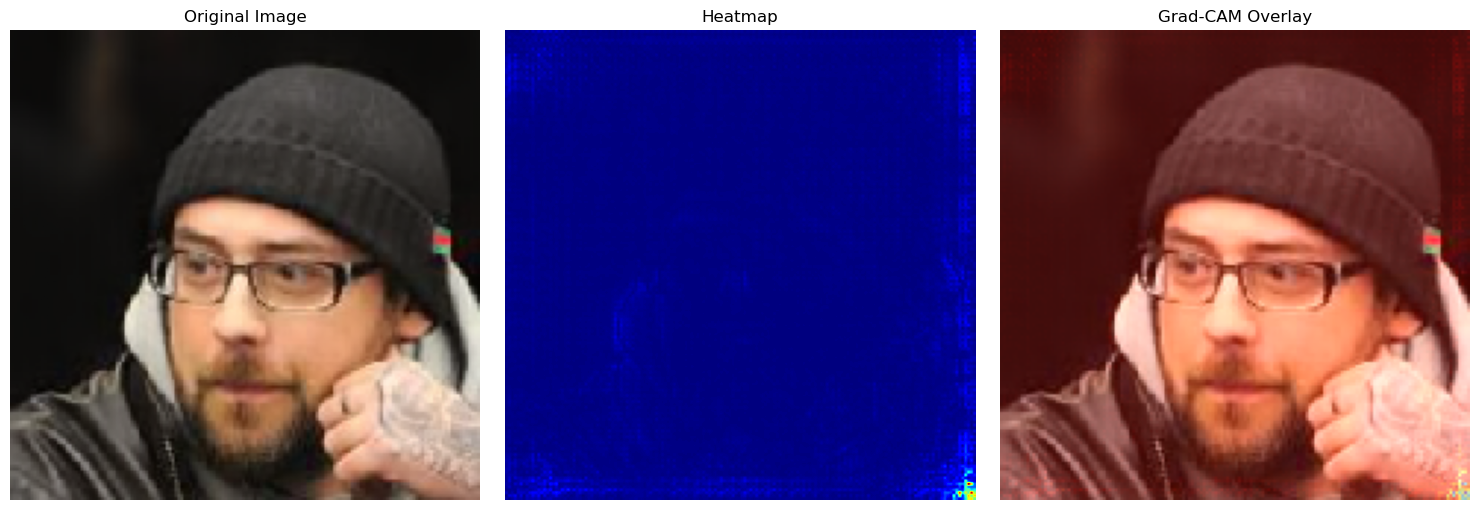

Fixed approach successful!


In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap_fixed(img_array, model, target_layer_name=None):
    """
    Fixed Grad-CAM implementation for EfficientNetB0-based models
    """
    # Get the EfficientNetB0 base model
    efficientnet = model.get_layer('efficientnetb0')
    
    # If no specific layer is provided, use the last convolutional layer
    if target_layer_name is None:
        # Find the last convolutional layer
        for layer in reversed(efficientnet.layers):
            if 'conv' in layer.name or 'project' in layer.name:
                target_layer_name = layer.name
                break
        print(f"Using layer: {target_layer_name}")
    
    # Get the target layer
    target_layer = efficientnet.get_layer(target_layer_name)
    
    # Create a new model that goes from input to target layer output and final predictions
    # This is the correct way to build the grad_model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[target_layer.output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        target_layer_output, preds = grad_model(img_array, training=False)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Get gradients of the output neuron with respect to the target layer output
    grads = tape.gradient(class_channel, target_layer_output)
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the feature maps by importance
    target_layer_output = target_layer_output[0]
    heatmap = target_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def preprocess_image(image_path, target_size=(160, 160)):
    """Preprocess image for model input"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

def display_gradcam(img_path, heatmap, alpha=0.4, target_size=(160, 160)):
    """Display Grad-CAM results"""
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize to [0, 1]

    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = heatmap_colored / 255.0
    
    # Superimpose the heatmap on original image
    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Display
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Alternative: Direct approach using model's layers
def direct_gradcam(img_array, model):
    """
    Direct Grad-CAM implementation that uses the model's layers directly
    """
    # Get the EfficientNetB0 base model output (before global average pooling)
    efficientnet = model.get_layer('efficientnetb0')
    
    # Create a model that outputs the feature maps and predictions
    feature_map_model = tf.keras.Model(
        inputs=model.input,
        outputs=[efficientnet.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        feature_maps, predictions = feature_map_model(img_array, training=False)
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]
    
    # Compute gradients
    grads = tape.gradient(class_output, feature_maps)
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the feature maps
    feature_maps = feature_maps[0]
    heatmap = tf.reduce_sum(feature_maps * pooled_grads, axis=-1)
    
    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()
# Simple saliency map as fallback
def create_saliency_map(img_array, model):
    """Create a simple saliency map using input gradients"""
    img_array = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array, training=False)
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]
    
    # Compute gradients of output with respect to input
    grads = tape.gradient(class_output, img_array)
    grads = tf.squeeze(grads)
    
    # Take absolute value and average across channels
    saliency = tf.reduce_mean(tf.abs(grads), axis=-1)
    saliency = saliency / tf.math.reduce_max(saliency)
    
    return saliency.numpy()


# Usage example:
image_path = "D:/thesis/dataset/deepfake dataset/1-GDWCT/62.png"

# Preprocess image
img_array = preprocess_image(image_path)

print("Testing different approaches...")
# Usage

# Try the fixed approach first
try:
    print("Trying fixed approach...")
    saliency_map = create_saliency_map(img_array, model)
    display_gradcam(image_path, saliency_map)
    print("Fixed approach successful!")
except Exception as e:
    print(f"Fixed approach failed: {e}")
    
    # Try direct approach
    try:
        print("Trying direct approach...")
        heatmap = direct_gradcam(img_array, model)
        display_gradcam(image_path, heatmap)
        print("Direct approach successful!")
    except Exception as e2:
        print(f"Direct approach also failed: {e2}")
        
        # Last resort: Manual gradient computation
        print("Trying manual gradient computation...")
        with tf.GradientTape() as tape:
            tape.watch(img_array)
            predictions = model(img_array, training=False)
            pred_index = tf.argmax(predictions[0])
            class_output = predictions[:, pred_index]
        
        # Get gradients with respect to input
        grads = tape.gradient(class_output, img_array)
        grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Create a simple heatmap from gradients
        heatmap = tf.reduce_mean(tf.abs(grads), axis=-1)
        heatmap = heatmap / tf.math.reduce_max(heatmap)
        
        display_gradcam(image_path, heatmap.numpy())
        print("Manual gradient approach completed")

resnet 50
Dataset: DFC
GDWCT


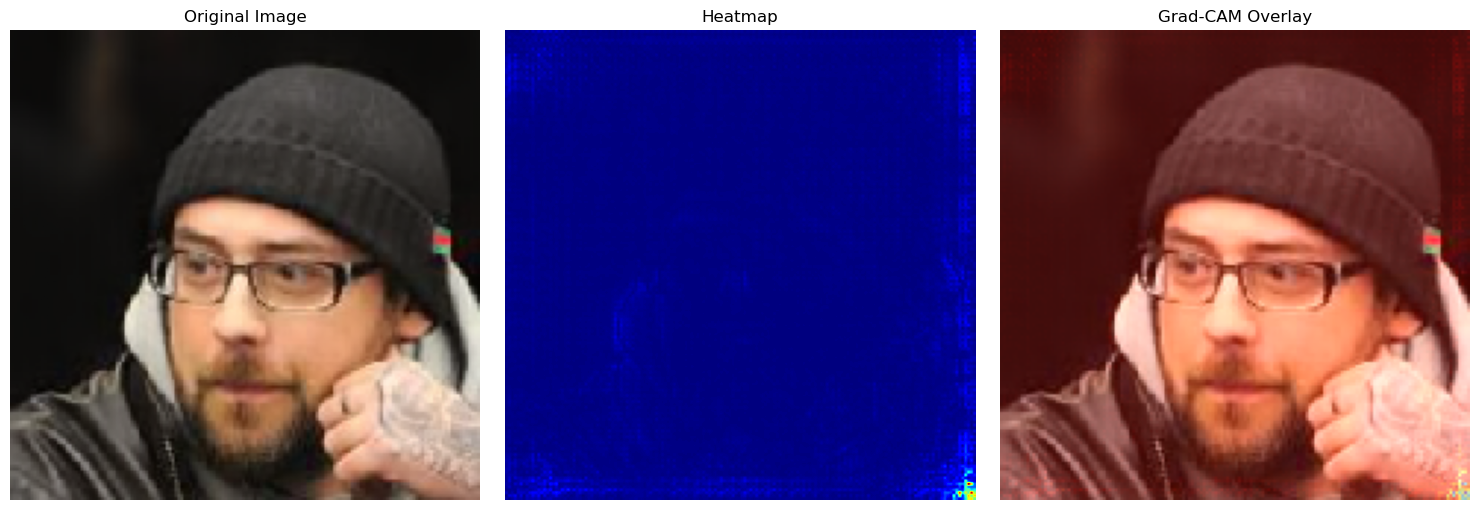

attaGan


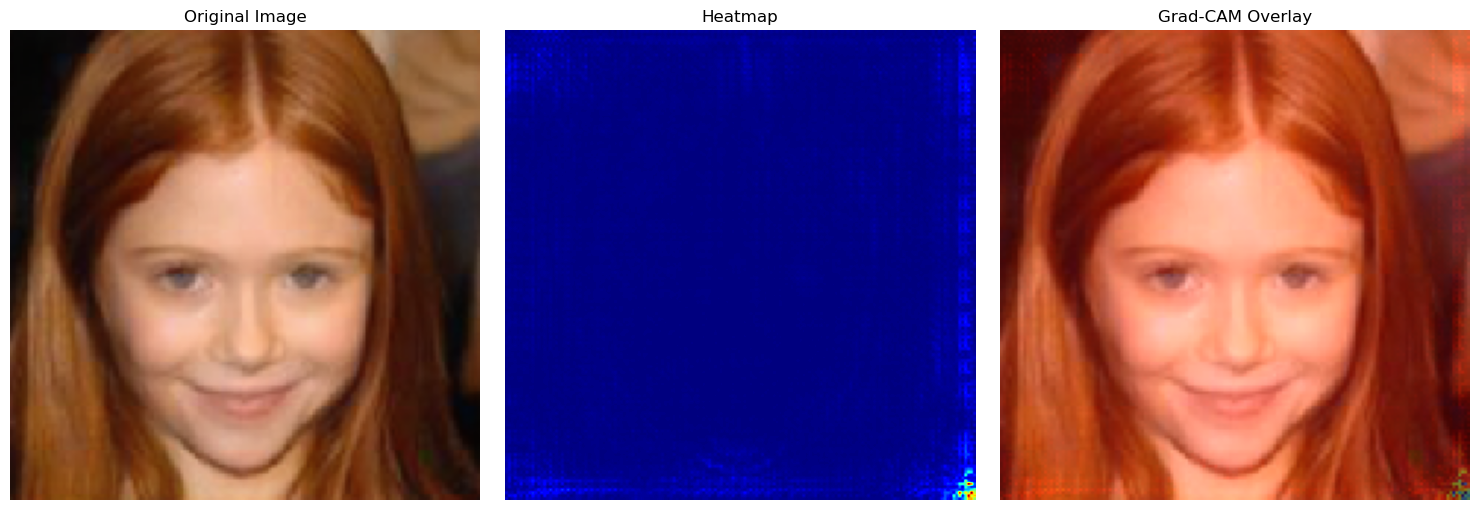

stargan


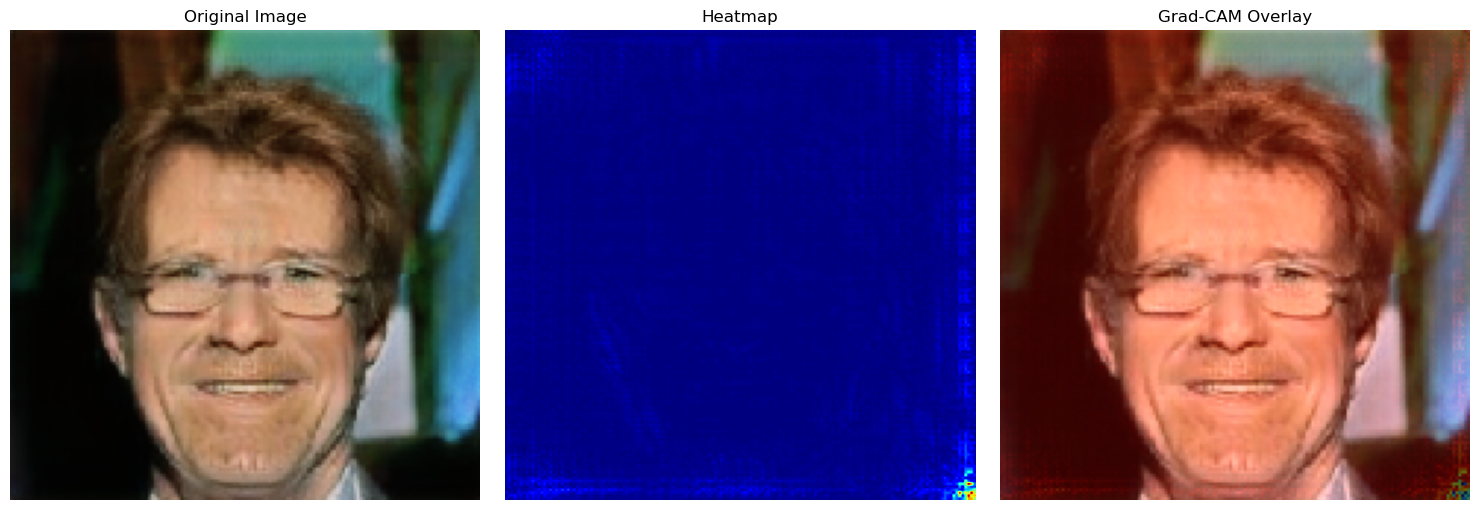

stylegan 2


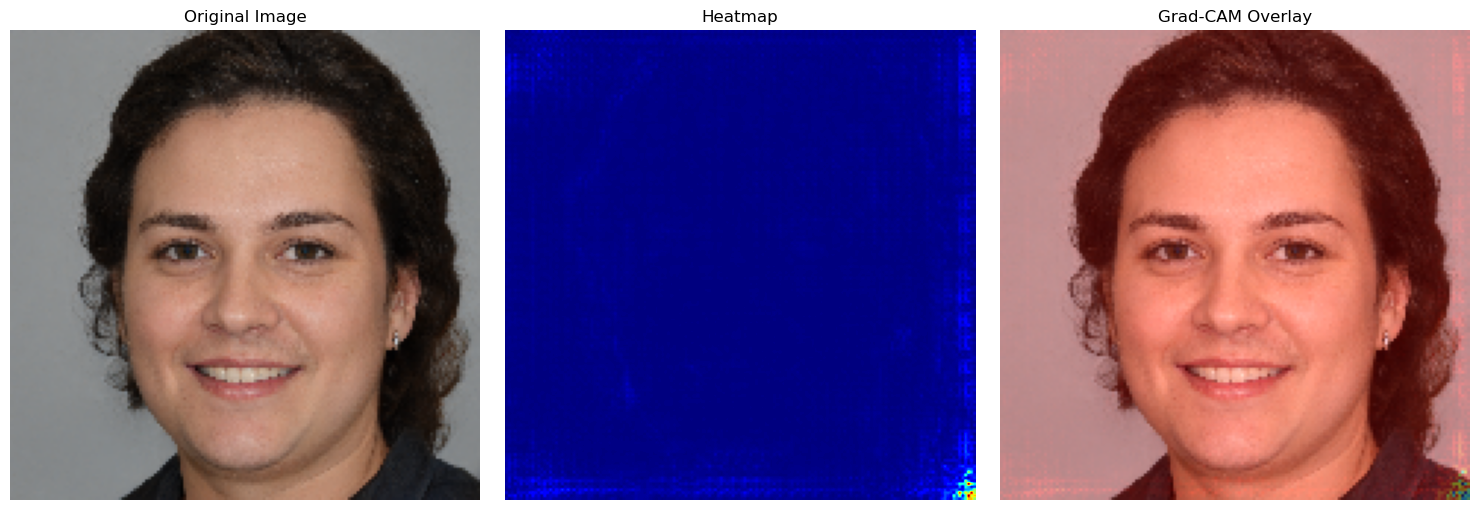

stylegan 1


ValueError: No such layer: resnet50. Existing layers are: ['input_2', 'efficientnetb0', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1'].

In [19]:
# Load and process image
print("resnet 50")
print("Dataset: DFC")
print("GDWCT")
image_path = "D:/thesis/dataset/deepfake dataset/1-GDWCT/62.png"
img_array = preprocess_image(image_path)
# Generate and display heatmap
saliency_map = create_saliency_map(img_array, model)
display_gradcam(image_path, saliency_map)
#######################################################################################################
print("attaGan")
image_path = "D:/thesis/dataset/deepfake dataset/1-ATTGAN/37.png"
img_array = preprocess_image(image_path)
# Generate and display heatmap
saliency_map = create_saliency_map(img_array, model)
display_gradcam(image_path, saliency_map)
#######################################################################################################
print("stargan")
image_path = "D:/thesis/dataset/deepfake dataset/1-StarGAN/image_200.png"
img_array = preprocess_image(image_path)
# Generate and display heatmap
saliency_map = create_saliency_map(img_array, model)
display_gradcam(image_path, saliency_map)
#######################################################################################################
print("stylegan 2")
image_path = "D:/thesis/dataset/deepfake dataset/1-STYLEGAN2/000200.png"
img_array = preprocess_image(image_path)

# Generate and display heatmap
saliency_map = create_saliency_map(img_array, model)
display_gradcam(image_path, saliency_map)
#######################################################################################################
print("stylegan 1")
image_path = "D:/thesis/dataset/deepfake dataset/1-STYLEGAN/000201.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
########################################################################################################
print("Dataset: Celeb")
image_path = "D:\\thesis\\dataset\\Celeb-DF-v2\\id00p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
#######################################################################################################
print("Dataset: FF++")
print("DFD")
image_path = "D:\\thesis\\dataset\\ff++\\manipulated_sequences\\dfd_001p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
#######################################################################################################
print("DF")
image_path = "D:\\thesis\\dataset\\ff++\\manipulated_sequences\\df_004_982p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
#######################################################################################################
print("Faceshifter")
image_path = "D:\\thesis\\dataset\\ff++\\manipulated_sequences\\faceshifter_004_982p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
#######################################################################################################
print("Faceswap")
image_path = "D:\\thesis\\dataset\\ff++\\manipulated_sequences\\faceswap_004_982p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
#######################################################################################################
print("F2f")
image_path = "D:\\thesis\\dataset\\ff++\\manipulated_sequences\\f2f_004_982p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)
#######################################################################################################
print("NT")
image_path = "D:\\thesis\\dataset\\ff++\\manipulated_sequences\\nt_004_982p.jpg"
img_array = preprocess_image(image_path)
# Generate and display heatmap
heatmap = make_gradcam_from_resnet_block(img_array, model, conv_layer_name='conv5_block3_out')
display_gradcam(image_path, heatmap)



# DFC

In [3]:
import h5py
import numpy as np
# Open the HDF5 file in read mode
with h5py.File('D://thesis//dataset//deepfake dataset//resized_images.h5', 'r') as h5f:
    # Access each dataset
    celeb = np.array(h5f['celeb'])
    ffhq = np.array(h5f['ffhq'])
    gdwct = np.array(h5f['gdwct'])
    attgan = np.array(h5f['attgan'])
    stargan = np.array(h5f['stargan'])
    stylegan2 = np.array(h5f['stylegan2'])
    stylegan = np.array(h5f['stylegan'])

# Now, 'celeb', 'ffhq', etc., are NumPy arrays containing your datasets
print(f"celeb shape: {celeb.shape}, dtype: {celeb.dtype}")
print(f"ffhq shape: {ffhq.shape}, dtype: {ffhq.dtype}")
print(f"ffhq shape: {gdwct.shape}, dtype: {gdwct.dtype}")
print(f"ffhq shape: {attgan.shape}, dtype: {attgan.dtype}")
print(f"ffhq shape: {stargan.shape}, dtype: {stargan.dtype}")
print(f"ffhq shape: {stylegan2.shape}, dtype: {stylegan2.dtype}")
print(f"ffhq shape: {stylegan.shape}, dtype: {stylegan.dtype}")
# Repeat for other datasets as needed
import cv2
# Function to resize images from (224, 224) to (160, 160)
def resize_images(image_array, target_size=(160, 160)):
    resized_images = np.array([cv2.resize(img, target_size) for img in image_array])
    return resized_images

celeb = resize_images(celeb, target_size=(160, 160))
ffhq = resize_images(ffhq, target_size=(160, 160))
gdwct = resize_images(gdwct, target_size=(160, 160))
attgan = resize_images(attgan, target_size=(160, 160))
stargan = resize_images(stargan, target_size=(160, 160))
stylegan = resize_images(stargan, target_size=(160, 160))
stylegan2 = resize_images(stylegan2, target_size=(160, 160))
import random
# Randomly select 2500 distinct images
random_indices = random.sample(range(len(celeb)), 2500)  # Get 2500 random indices
celeb = celeb[random_indices]  # Select the random subse

import random
# Randomly select 2500 distinct images
random_indices = random.sample(range(len(ffhq)), 2500)  # Get 2500 random indices
ffhq = ffhq[random_indices]  # Select the random subse
print(f"celeb shape: {celeb.shape}, dtype: {celeb.dtype}")
print(f"ffhq shape: {ffhq.shape}, dtype: {ffhq.dtype}")
print(f"gdwct shape: {gdwct.shape}, dtype: {gdwct.dtype}")
print(f"attagan shape: {attgan.shape}, dtype: {attgan.dtype}")
print(f"stargan shape: {stargan.shape}, dtype: {stargan.dtype}")
print(f"stylegan2 shape: {stylegan2.shape}, dtype: {stylegan2.dtype}")
print(f"stylegan shape: {stylegan.shape}, dtype: {stylegan.dtype}")
import random
import numpy as np

def split_data(data, train_ratio=0.7):
    """
    Splits data into training and testing sets based on the specified ratio.

    Parameters:
        data (list or np.array): The dataset to split.
        train_ratio (float): The ratio of the data to include in the training set.

    Returns:
        tuple: Two datasets - train and test.
    """
    # Shuffle the data
    random.shuffle(data)

    # Calculate the split index
    split_index = int(len(data) * train_ratio)

    # Split the data
    train_data = data[:split_index]
    test_data = data[split_index:]

    return train_data, test_data

# Split `celeb` into 70% train and 30% test
celeb_train_hog, celeb_test_hog = split_data(celeb, train_ratio=0.7)

# Split `ffhq` into 70% train and 30% test
ffhq_train_hog, ffhq_test_hog = split_data(ffhq, train_ratio=0.7)

# Split `attgan` into 70% train and 30% test
attgan_train_hog, attgan_test_hog = split_data(attgan, train_ratio=0.7)

# Split `stargan` into 70% train and 30% test
stargan_train_hog, stargan_test_hog = split_data(stargan, train_ratio=0.7)

# Split `gdwct` into 70% train and 30% test
gdwct_train_hog, gdwct_test_hog = split_data(gdwct, train_ratio=0.7)

# Split `stylegan2` into 70% train and 30% test_hog
stylegan2_train_hog, stylegan2_test_hog = split_data(stylegan2, train_ratio=0.7)

# Split `stylegan` into 70% train and 30% test_hog
stylegan_train_hog, stylegan_test_hog = split_data(stylegan, train_ratio=0.7)

# Convert to NumPy arrays if needed
celeb_train_hog, celeb_test_hog = np.array(celeb_train_hog), np.array(celeb_test_hog)
ffhq_train_hog, ffhq_test_hog = np.array(ffhq_train_hog), np.array(ffhq_test_hog)
attgan_train_hog, attgan_test_hog = np.array(attgan_train_hog), np.array(attgan_test_hog)
stargan_train_hog, stargan_test_hog = np.array(stargan_train_hog), np.array(stargan_test_hog)
gdwct_train_hog, gdwct_test_hog = np.array(gdwct_train_hog), np.array(gdwct_test_hog)
stylegan2_train_hog, stylegan2_test_hog = np.array(stylegan2_train_hog), np.array(stylegan2_test_hog)
stylegan_train_hog, stylegan_test_hog = np.array(stylegan_train_hog), np.array(stylegan_test_hog)

# Print results for verification
print(f"celeb_train: {len(celeb_train_hog)} images, celeb_test: {len(celeb_test_hog)} images")
print(f"ffhq_train: {len(ffhq_train_hog)} images, ffhq_test: {len(ffhq_test_hog)} images")
print(f"attgan_train: {len(attgan_train_hog)} images, attgan_test: {len(attgan_test_hog)} images")
print(f"stargan_train: {len(stargan_train_hog)} images, stargan_test: {len(stargan_test_hog)} images")
print(f"gdwct_train: {len(gdwct_train_hog)} images, gdwct_test: {len(gdwct_test_hog)} images")
print(f"stylegan2_train: {len(stylegan2_train_hog)} images, stylegan2_test: {len(stylegan2_test_hog)} images")
print(f"stylegan_train: {len(stylegan_train_hog)} images, stylegan_test: {len(stylegan_test_hog)} images")

########################################################################################################################################
#######################################divide into 60,10 train and val
#########################################################################################################################################
def extract_validation(train_data):
    """
    Extract every 10th sample from the training data and store it in a validation set.

    Parameters:
        train_data (list or np.array): The training dataset.

    Returns:
        tuple: Updated training dataset and validation dataset.
    """
    # Select every 10th sample for the validation set
    validation_data = train_data[::10]

    # Remove the selected samples from the training dataset
    updated_train_data = [train_data[i] for i in range(len(train_data)) if i % 10 != 0]

    return np.array(updated_train_data), np.array(validation_data)


# Perform the operation for each dataset
celeb_train_hog, celeb_val_hog = extract_validation(celeb_train_hog)
ffhq_train_hog, ffhq_val_hog = extract_validation(ffhq_train_hog)
attgan_train_hog, attgan_val_hog = extract_validation(attgan_train_hog)
stargan_train_hog, stargan_val_hog = extract_validation(stargan_train_hog)
gdwct_train_hog, gdwct_val_hog = extract_validation(gdwct_train_hog)
stylegan2_train_hog, stylegan2_val_hog = extract_validation(stylegan2_train_hog)
stylegan_train_hog, stylegan_val_hog = extract_validation(stylegan_train_hog)

# Print results for verification
print(f"celeb_train: {len(celeb_train_hog)} images, celeb_val: {len(celeb_val_hog)} images")
print(f"ffhq_train: {len(ffhq_train_hog)} images, ffhq_val: {len(ffhq_val_hog)} images")
print(f"attgan_train: {len(attgan_train_hog)} images, attgan_val: {len(attgan_val_hog)} images")
print(f"stargan_train: {len(stargan_train_hog)} images, stargan_val: {len(stargan_val_hog)} images")
print(f"gdwct_train: {len(gdwct_train_hog)} images, gdwct_val: {len(gdwct_val_hog)} images")
print(f"stylegan2_train: {len(stylegan2_train_hog)} images, stylegan2_val: {len(stylegan2_val_hog)} images")
print(f"stylegan_train: {len(stylegan_train_hog)} images, stylegan_val: {len(stylegan_val_hog)} images")
############################################################################################################################################################
#################################################concatenate the labels 0,1 real and fake
#############################################################################################################################################################


celeb_train_labels = np.zeros(len(celeb_train_hog), dtype=int)
ffhq_train_labels = np.zeros(len(ffhq_train_hog), dtype=int)
atta_train_labels = np.ones(len(attgan_train_hog), dtype=int)
star_train_labels = np.ones(len(stargan_train_hog), dtype=int)
gdwct_train_labels = np.ones(len(gdwct_train_hog), dtype=int)
stylegan2_train_labels = np.ones(len(stylegan2_train_hog), dtype=int)
stylegan_train_labels = np.ones(len(stylegan_train_hog), dtype=int)

# Concatenate all training datasets into a single `train` variable
train_hog = np.concatenate([celeb_train_hog, ffhq_train_hog, attgan_train_hog, stargan_train_hog, gdwct_train_hog, stylegan2_train_hog, stylegan_train_hog], axis=0)
train_labels=np.concatenate([celeb_train_labels, ffhq_train_labels, atta_train_labels, star_train_labels, gdwct_train_labels, stylegan2_train_labels,
                              stylegan_train_labels], axis=0)




celeb_test_labels = np.zeros(len(celeb_test_hog), dtype=int)
ffhq_test_labels = np.zeros(len(ffhq_test_hog), dtype=int)
atta_test_labels = np.ones(len(attgan_test_hog), dtype=int)
star_test_labels = np.ones(len(stargan_test_hog), dtype=int)
gdwct_test_labels = np.ones(len(gdwct_test_hog), dtype=int)
stylegan2_test_labels = np.ones(len(stylegan2_test_hog), dtype=int)
stylegan_test_labels = np.ones(len(stylegan_test_hog), dtype=int)

# Concatenate all testing datasets into a single `test` variable
test_hog = np.concatenate([celeb_test_hog, ffhq_test_hog, attgan_test_hog, stargan_test_hog, gdwct_test_hog, stylegan2_test_hog, stylegan_test_hog], axis=0)
test_labels = np.concatenate([celeb_test_labels, ffhq_test_labels, atta_test_labels, star_test_labels, gdwct_test_labels, stylegan2_test_labels,
                        stylegan_test_labels], axis=0)




celeb_val_labels = np.zeros(len(celeb_val_hog), dtype=int)
ffhq_val_labels = np.zeros(len(ffhq_val_hog), dtype=int)
atta_val_labels = np.ones(len(attgan_val_hog), dtype=int)
star_val_labels = np.ones(len(stargan_val_hog), dtype=int)
gdwct_val_labels = np.ones(len(gdwct_val_hog), dtype=int)
stylegan2_val_labels = np.ones(len(stylegan2_val_hog), dtype=int)
stylegan_val_labels = np.ones(len(stylegan_val_hog), dtype=int)

# Concatenate all validation datasets into a single `val` variable
val_hog = np.concatenate([celeb_val_hog, ffhq_val_hog, attgan_val_hog, stargan_val_hog, gdwct_val_hog, stylegan2_val_hog, stylegan_val_hog], axis=0)
val_labels = np.concatenate([celeb_val_labels, ffhq_val_labels, atta_val_labels, star_val_labels, gdwct_val_labels, stylegan2_val_labels,
                       stylegan_val_labels], axis=0)

# Print the results for verification
print(f"Total train: {len(train_hog)} images")
print(f"Total test: {len(test_hog)} images")
print(f"Total val: {len(val_hog)} images")


# Print results for verification
print(f"Train Labels: {len(train_labels)} ")
print(f"Test Labels: {len(test_labels)} ")
print(f"Val Labels: {len(val_labels)} ")



celeb shape: (5000, 224, 224, 3), dtype: uint8
ffhq shape: (5000, 224, 224, 3), dtype: uint8
ffhq shape: (1000, 224, 224, 3), dtype: uint8
ffhq shape: (1000, 224, 224, 3), dtype: uint8
ffhq shape: (1000, 224, 224, 3), dtype: uint8
ffhq shape: (1000, 224, 224, 3), dtype: uint8
ffhq shape: (1000, 224, 224, 3), dtype: uint8
celeb shape: (2500, 160, 160, 3), dtype: uint8
ffhq shape: (2500, 160, 160, 3), dtype: uint8
gdwct shape: (1000, 160, 160, 3), dtype: uint8
attagan shape: (1000, 160, 160, 3), dtype: uint8
stargan shape: (1000, 160, 160, 3), dtype: uint8
stylegan2 shape: (1000, 160, 160, 3), dtype: uint8
stylegan shape: (1000, 160, 160, 3), dtype: uint8
celeb_train: 1750 images, celeb_test: 750 images
ffhq_train: 1750 images, ffhq_test: 750 images
attgan_train: 700 images, attgan_test: 300 images
stargan_train: 700 images, stargan_test: 300 images
gdwct_train: 700 images, gdwct_test: 300 images
stylegan2_train: 700 images, stylegan2_test: 300 images
stylegan_train: 700 images, stylegan

In [5]:


# Train the model
history = model.fit(
    train_hog, train_labels,
    validation_data=(val_hog, val_labels),
    epochs=100,
    batch_size=32
)

Epoch 1/100
197/197 [==============================] - 14s 29ms/step - loss: 0.5318 - accuracy: 0.7435 - auc: 0.8293 - val_loss: 0.4253 - val_accuracy: 0.8229 - val_auc: 0.9073
Epoch 2/100
197/197 [==============================] - 6s 33ms/step - loss: 0.3792 - accuracy: 0.8497 - auc: 0.9266 - val_loss: 0.3376 - val_accuracy: 0.8671 - val_auc: 0.9444
Epoch 3/100
197/197 [==============================] - 11s 56ms/step - loss: 0.3137 - accuracy: 0.8762 - auc: 0.9504 - val_loss: 0.2911 - val_accuracy: 0.8900 - val_auc: 0.9580
Epoch 4/100
197/197 [==============================] - 11s 54ms/step - loss: 0.2736 - accuracy: 0.8994 - auc: 0.9632 - val_loss: 0.2589 - val_accuracy: 0.9057 - val_auc: 0.9658
Epoch 5/100
197/197 [==============================] - 5s 25ms/step - loss: 0.2441 - accuracy: 0.9113 - auc: 0.9707 - val_loss: 0.2466 - val_accuracy: 0.9043 - val_auc: 0.9703
Epoch 6/100
197/197 [==============================] - 5s 24ms/step - loss: 0.2171 - accuracy: 0.9252 - auc: 0.9779 -

In [4]:


# Train the model
history = model.fit(
    train_hog, train_labels,
    validation_data=(val_hog, val_labels),
    epochs=100,
    batch_size=32
)

Epoch 1/100
197/197 [==============================] - 11s 29ms/step - loss: 0.5291 - accuracy: 0.7517 - auc: 0.8301 - val_loss: 0.4329 - val_accuracy: 0.8043 - val_auc: 0.9054
Epoch 2/100
197/197 [==============================] - 5s 23ms/step - loss: 0.3856 - accuracy: 0.8430 - auc: 0.9207 - val_loss: 0.3494 - val_accuracy: 0.8643 - val_auc: 0.9386
Epoch 3/100
197/197 [==============================] - 5s 23ms/step - loss: 0.3227 - accuracy: 0.8783 - auc: 0.9463 - val_loss: 0.3024 - val_accuracy: 0.8857 - val_auc: 0.9537
Epoch 4/100
197/197 [==============================] - 5s 23ms/step - loss: 0.2808 - accuracy: 0.8987 - auc: 0.9598 - val_loss: 0.2721 - val_accuracy: 0.9057 - val_auc: 0.9618
Epoch 5/100
197/197 [==============================] - 5s 23ms/step - loss: 0.2489 - accuracy: 0.9143 - auc: 0.9689 - val_loss: 0.2499 - val_accuracy: 0.9086 - val_auc: 0.9668
Epoch 6/100
197/197 [==============================] - 5s 23ms/step - loss: 0.2245 - accuracy: 0.9238 - auc: 0.9751 - v

In [6]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_hog, test_labels)
print(f'\nTest Accuracy of DFC on Efficent net: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test_hog)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_binary))

94/94 [==============================] - 2s 22ms/step - loss: 0.2972 - accuracy: 0.9373 - auc: 0.9739

Test Accuracy of DFC on Efficent net: 93.73%
94/94 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1500
           1       0.95      0.92      0.94      1500

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [5]:
print("=== DATA LOADING ===")
start = monitor.get_stats()
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_hog, test_labels)
print(f'\nTest Accuracy of DFC on EfficientNetB0: {test_acc*100:.2f}%')
# Your data loading operations here
time.sleep(2)  # Simulate loading time

end = monitor.get_stats()
duration = end['timestamp'] - start['timestamp']

print("\n=== RESOURCE USAGE ===")
print(f"CPU Usage: {end['cpu_%']:.1f}%")
print(f"RAM Used: {end['ram_mb'] - start['ram_mb']:.1f} MB")
print(f"Time Usage: {duration:.1f} s")
print(f"GPU Memory Used: {end['gpu_mem_mb']:.1f} MB")
print(f"Power Consumption: {int(end['power_w'])}W")  # Rounded to whole watts

=== DATA LOADING ===
94/94 [==============================] - 2s 20ms/step - loss: 0.2556 - accuracy: 0.9453 - auc: 0.9768

Test Accuracy of DFC on EfficientNetB0: 94.53%

=== RESOURCE USAGE ===
CPU Usage: 6.1%
RAM Used: 262.6 MB
Time Usage: 4.1 s
GPU Memory Used: 751.6 MB
Power Consumption: 93W


In [8]:
# Your data loading operations here
time.sleep(2)  # Simulate loading time

end = monitor.get_stats()
duration = end['timestamp'] - start['timestamp']

print("\n=== RESOURCE USAGE ===")
print(f"CPU Usage: {end['cpu_%']:.1f}%")
print(f"RAM Used: {end['ram_mb'] - start['ram_mb']:.1f} MB")
print(f"Time Usage: {duration:.1f} s")
print(f"GPU Memory Used: {end['gpu_mem_mb']:.1f} MB")
print(f"Power Consumption: {int(end['power_w'])}W")  # Rounded to whole watts


=== RESOURCE USAGE ===
CPU Usage: 12.0%
RAM Used: 4325.0 MB
Time Usage: 1423.8 s
GPU Memory Used: 19.2 MB
Power Consumption: 93W


In [9]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test, test_labels)
print(f'\nTest Accuracy of Celeb-df dataset on Efficentnet for DFC: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_binary))

340/340 [==============================] - 7s 21ms/step - loss: 2.6444 - accuracy: 0.6719 - auc: 0.4901

Test Accuracy of Celeb-df dataset on Efficentnet for DFC: 67.19%
340/340 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

           0       0.27      0.12      0.16      2961
           1       0.73      0.88      0.80      7891

    accuracy                           0.67     10852
   macro avg       0.50      0.50      0.48     10852
weighted avg       0.60      0.67      0.62     10852



In [11]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_ff, test_labels_ff)
print(f'\nTest Accuracy of FF++ dataset on Efficentnet for DFC: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test_ff)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels_ff, y_pred_binary))

169/169 [==============================] - 4s 21ms/step - loss: 2.6739 - accuracy: 0.6142 - auc: 0.5226

Test Accuracy of FF++ dataset on Efficentnet for DFC: 61.42%
169/169 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           0       0.29      0.29      0.29      1468
           1       0.74      0.73      0.73      3911

    accuracy                           0.61      5379
   macro avg       0.51      0.51      0.51      5379
weighted avg       0.61      0.61      0.61      5379



# FF++

In [2]:
import h5py

# Open the HDF5 file for reading
with h5py.File("D://thesis//dataset//ff++//images_ff++_orignal_processed.h5", "r") as h5f:
    org_seq_actor_array = h5f["ori_actor"][:]
    org_seq_youtube_array = h5f["ori_youtube"][:]
print("Data loaded successfully from the HDF5 file.")
with h5py.File("D://thesis//dataset//ff++//images_ff++_fake1_processed.h5", "r") as h5f:
    meni_seq_dfd_array = h5f["mni_dfd"][:]
    meni_seq_df_array = h5f["mni_df"][:]
print("Data loaded successfully from the HDF5 file.")
with h5py.File("D://thesis//dataset//ff++//images_ff++_fake2_processed.h5", "r") as h5f:
    meni_seq_f2f_array = h5f["mni_f2f"][:]
    meni_seq_fshifter_array = h5f["mni_fshifter"][:]
print("Data loaded successfully from the HDF5 file.")
with h5py.File("D://thesis//dataset//ff++//images_ff++_fake3_processed.h5", "r") as h5f:
    meni_seq_fswap_array = h5f["mni_fswap"][:]
    meni_seq_nt_array = h5f["mni_nt"][:]
print("Data loaded successfully from the HDF5 file.")
# Output the shape of the resulting array
print(f"Shape of the concatenated array: {org_seq_actor_array.shape}")
print(f"Shape of the concatenated array: {org_seq_youtube_array.shape}")

print(f"Shape of the concatenated array: {meni_seq_dfd_array.shape}")
print(f"Shape of the concatenated array: {meni_seq_df_array.shape}")
print(f"Shape of the concatenated array: {meni_seq_fshifter_array.shape}")
print(f"Shape of the concatenated array: {meni_seq_f2f_array.shape}")
print(f"Shape of the concatenated array: {meni_seq_fswap_array.shape}")
print(f"Shape of the concatenated array: {meni_seq_nt_array.shape}")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

ori_actor_train_real, ori_actor_test_real = train_test_split(org_seq_actor_array, test_size=0.3, random_state=42)
ori_youtube_train_real, ori_youtube_test_real = train_test_split(org_seq_youtube_array, test_size=0.3, random_state=42)
# Split the data into train (70%) and test (30%)
mni_dfd_train_fake, mni_dfd_test_fake = train_test_split(meni_seq_dfd_array, test_size=0.3, random_state=42)
mni_df_train_fake, mni_df_test_fake = train_test_split(meni_seq_df_array, test_size=0.3, random_state=42)
mni_f2f_train_fake, mni_f2f_test_fake = train_test_split(meni_seq_f2f_array, test_size=0.3, random_state=42)
mni_fshifter_train_fake, mni_fshifter_test_fake = train_test_split(meni_seq_fshifter_array, test_size=0.3, random_state=42)
mni_fswap_train_fake, mni_fswap_test_fake = train_test_split(meni_seq_fswap_array, test_size=0.3, random_state=42)
mni_nt_train_fake, mni_nt_test_fake = train_test_split(meni_seq_nt_array, test_size=0.3, random_state=42)


# Output the shape to confirm the split dimensions
print("Training data ACTOR real shape:", ori_actor_train_real.shape, "Testing real data shape:", ori_actor_test_real.shape)
print("Training data Youtube real shape:", ori_youtube_train_real.shape, "Testing real data shape:", ori_youtube_test_real.shape)

print("Training data DFD fake shape:", mni_dfd_train_fake.shape, "Testing fake data shape:", mni_dfd_test_fake.shape)
print("Training data DF fake shape:", mni_df_train_fake.shape, "Testing fake data shape:", mni_df_test_fake.shape)
print("Training data f2f fake shape:", mni_f2f_train_fake.shape, "Testing fake data shape:", mni_f2f_test_fake.shape)
print("Training data fshifter fake shape:", mni_fshifter_train_fake.shape, "Testing fake data shape:", mni_fshifter_test_fake.shape)
print("Training data fswap fake shape:", mni_fswap_train_fake.shape, "Testing fake data shape:", mni_fswap_test_fake.shape)
print("Training data nt fake shape:", mni_nt_train_fake.shape, "Testing fake data shape:", mni_nt_test_fake.shape)
########################################################################################################################################
#######################################divide into 60,10 train and val
#########################################################################################################################################
def extract_validation(train_data):
    """
    Extract every 10th sample from the training data and store it in a validation set.

    Parameters:
        train_data (list or np.array): The training dataset.

    Returns:
        tuple: Updated training dataset and validation dataset.
    """
    # Select every 10th sample for the validation set
    validation_data = train_data[::10]

    # Remove the selected samples from the training dataset
    updated_train_data = [train_data[i] for i in range(len(train_data)) if i % 10 != 0]

    return np.array(updated_train_data), np.array(validation_data)


# Perform the operation for each dataset
train_hog_ori_actor_real, val_hog_ori_actor_real = extract_validation(ori_actor_train_real)
train_hog_ori_youtube_real, val_hog_ori_youtube_real = extract_validation(ori_youtube_train_real)
train_hog_mni_dfd_fake, val_hog_mni_dfd_fake = extract_validation(mni_dfd_train_fake)
train_hog_mni_df_fake, val_hog_mni_df_fake = extract_validation(mni_df_train_fake)
train_hog_mni_f2f_fake, val_hog_mni_f2f_fake = extract_validation(mni_f2f_train_fake)
train_hog_mni_fshifter_fake, val_hog_mni_fshifter_fake = extract_validation(mni_fshifter_train_fake)
train_hog_mni_fswap_fake, val_hog_mni_fswap_fake = extract_validation(mni_fswap_train_fake)
train_hog_mni_nt_fake, val_hog_mni_nt_fake = extract_validation(mni_nt_train_fake)
# Print results for verification
print(f"train_ori_actor hog_real: {len(train_hog_ori_actor_real)} images, val_ori_actor hog_real: {len(val_hog_ori_actor_real)} images")
print(f"train_ ori_youtube hog_real: {len(train_hog_ori_youtube_real)} images, val_ ori_youtube hog_real: {len(val_hog_ori_youtube_real)} images")
print(f"train_hog_mni_dfd_fake: {len(train_hog_mni_dfd_fake)} images, val_hog_mni_dfd_fake: {len(val_hog_mni_dfd_fake)} images")
print(f"train_hog_mni_df_fake: {len(train_hog_mni_df_fake)} images, val_hog_mni_df_fake: {len(val_hog_mni_df_fake)} images")
print(f"train_hog_mni_f2f_fake: {len(train_hog_mni_f2f_fake)} images, val_hog_mni_f2f_fake: {len(val_hog_mni_f2f_fake)} images")
print(f"train_hog_mni_fshifter_fake: {len(train_hog_mni_fshifter_fake)} images, val_hog_mni_fshifter_fake: {len(val_hog_mni_fshifter_fake)} images")
print(f"train_hog_mni_fswap_fake: {len(train_hog_mni_fswap_fake)} images, val_hog_mni_fswap_fake: {len(val_hog_mni_fswap_fake)} images")
print(f"train_hog_mni_nt_fake: {len(train_hog_mni_nt_fake)} images, val_hog_mni_nt_fake: {len(val_hog_mni_nt_fake)} images")
############################################################################################################################################################
#################################################concatenate the labels 0,1 real and fake
#############################################################################################################################################################


train_ori_actor_labels_real = np.zeros(len(train_hog_ori_actor_real), dtype=int)
train_ori_youtube_labels_real = np.zeros(len(train_hog_ori_youtube_real), dtype=int)
train_mni_dfd_labels_fake = np.ones(len(train_hog_mni_dfd_fake), dtype=int)
train_mni_df_labels_fake = np.ones(len(train_hog_mni_df_fake), dtype=int)
train_mni_f2f_labels_fake = np.ones(len(train_hog_mni_f2f_fake), dtype=int)
train_mni_fshifter_labels_fake = np.ones(len(train_hog_mni_fshifter_fake), dtype=int)
train_mni_fswap_labels_fake = np.ones(len(train_hog_mni_fswap_fake), dtype=int)
train_mni_nt_labels_fake = np.ones(len(train_hog_mni_nt_fake), dtype=int)

test_ori_actor_labels_real = np.zeros(len(ori_actor_test_real), dtype=int)
test_ori_youtube_labels_real = np.zeros(len(ori_youtube_test_real), dtype=int)
test_mni_dfd_labels_fake = np.ones(len(mni_dfd_test_fake), dtype=int)
test_mni_df_labels_fake = np.ones(len(mni_df_test_fake), dtype=int)
test_mni_f2f_labels_fake = np.ones(len(mni_f2f_test_fake), dtype=int)
test_mni_fshifter_labels_fake = np.ones(len(mni_fshifter_test_fake), dtype=int)
test_mni_fswap_labels_fake = np.ones(len(mni_fswap_test_fake), dtype=int)
test_mni_nt_labels_fake = np.ones(len(mni_nt_test_fake), dtype=int)


val_ori_actor_labels_real = np.zeros(len(val_hog_ori_actor_real), dtype=int)
val_ori_youtube_labels_real = np.zeros(len(val_hog_ori_youtube_real), dtype=int)
val_mni_dfd_labels_fake = np.ones(len(val_hog_mni_dfd_fake), dtype=int)
val_mni_df_labels_fake = np.ones(len(val_hog_mni_df_fake), dtype=int)
val_mni_f2f_labels_fake = np.ones(len(val_hog_mni_f2f_fake), dtype=int)
val_mni_fshifter_labels_fake = np.ones(len(val_hog_mni_fshifter_fake), dtype=int)
val_mni_fswap_labels_fake = np.ones(len(val_hog_mni_fswap_fake), dtype=int)
val_mni_nt_labels_fake = np.ones(len(val_hog_mni_nt_fake), dtype=int)
##################################################################################################################

# Concatenate all training datasets into a single `train` variable
train_ff = np.concatenate([train_hog_ori_actor_real, train_hog_ori_youtube_real,train_hog_mni_dfd_fake,train_hog_mni_df_fake,
                            train_hog_mni_f2f_fake,train_hog_mni_fshifter_fake,train_hog_mni_fswap_fake,train_hog_mni_nt_fake], axis=0)

train_labels_ff = np.concatenate([train_ori_actor_labels_real, train_ori_youtube_labels_real,train_mni_dfd_labels_fake,train_mni_df_labels_fake,
                            train_mni_f2f_labels_fake,train_mni_fshifter_labels_fake,train_mni_fswap_labels_fake,train_mni_nt_labels_fake], axis=0)

# Concatenate all validation datasets into a single `val` variable
val_ff = np.concatenate([val_hog_ori_actor_real, val_hog_ori_youtube_real, val_hog_mni_dfd_fake, val_hog_mni_df_fake,
                            val_hog_mni_f2f_fake, val_hog_mni_fshifter_fake, val_hog_mni_fswap_fake, val_hog_mni_nt_fake], axis=0)
val_labels_ff = np.concatenate([val_ori_actor_labels_real, val_ori_youtube_labels_real, val_mni_dfd_labels_fake, val_mni_df_labels_fake,
                            val_mni_f2f_labels_fake, val_mni_fshifter_labels_fake, val_mni_fswap_labels_fake, val_mni_nt_labels_fake], axis=0)
# Concatenate all testing datasets into a single `test` variable
test_ff = np.concatenate([ori_actor_test_real, ori_youtube_test_real, mni_dfd_test_fake,
                           mni_df_test_fake, mni_f2f_test_fake, mni_fshifter_test_fake,
                           mni_fswap_test_fake, mni_nt_test_fake], axis=0)
test_labels_ff = np.concatenate([test_ori_actor_labels_real, test_ori_youtube_labels_real, test_mni_dfd_labels_fake, test_mni_df_labels_fake,
                            test_mni_f2f_labels_fake, test_mni_fshifter_labels_fake, test_mni_fswap_labels_fake, test_mni_nt_labels_fake], axis=0)


# Print the results for verification
# Print the results for verification
print(f"Total train: {len(train_ff)} images, and shape:{train_ff.shape}")
print(f"Total test: {len(test_ff)} images, and shape:{test_ff.shape}")
print(f"Total val: {len(val_ff)} images, and shape:{val_ff.shape}")


# Print results for verification
print(f"Train Labels: {len(train_labels_ff)} ")
print(f"Test Labels: {len(test_labels_ff)} ")
print(f"Val Labels: {len(val_labels_ff)} ")





Data loaded successfully from the HDF5 file.
Data loaded successfully from the HDF5 file.
Data loaded successfully from the HDF5 file.
Data loaded successfully from the HDF5 file.
Shape of the concatenated array: (2808, 160, 160, 3)
Shape of the concatenated array: (2083, 160, 160, 3)
Shape of the concatenated array: (3299, 160, 160, 3)
Shape of the concatenated array: (2083, 160, 160, 3)
Shape of the concatenated array: (2083, 160, 160, 3)
Shape of the concatenated array: (2083, 160, 160, 3)
Shape of the concatenated array: (1742, 160, 160, 3)
Shape of the concatenated array: (1742, 160, 160, 3)
Training data ACTOR real shape: (1965, 160, 160, 3) Testing real data shape: (843, 160, 160, 3)
Training data Youtube real shape: (1458, 160, 160, 3) Testing real data shape: (625, 160, 160, 3)
Training data DFD fake shape: (2309, 160, 160, 3) Testing fake data shape: (990, 160, 160, 3)
Training data DF fake shape: (1458, 160, 160, 3) Testing fake data shape: (625, 160, 160, 3)
Training data f

In [5]:
# Train the model
history = model.fit(
    train_ff, train_labels_ff,
    validation_data=(val_ff, val_labels_ff),
    epochs=100,
    batch_size=32
)

Epoch 1/100
353/353 [==============================] - 16s 27ms/step - loss: 0.5607 - accuracy: 0.7334 - auc: 0.6410 - val_loss: 0.5448 - val_accuracy: 0.7373 - val_auc: 0.6782
Epoch 2/100
353/353 [==============================] - 8s 24ms/step - loss: 0.5422 - accuracy: 0.7445 - auc: 0.6761 - val_loss: 0.5376 - val_accuracy: 0.7381 - val_auc: 0.6880
Epoch 3/100
353/353 [==============================] - 9s 24ms/step - loss: 0.5328 - accuracy: 0.7517 - auc: 0.6902 - val_loss: 0.5356 - val_accuracy: 0.7436 - val_auc: 0.6903
Epoch 4/100
353/353 [==============================] - 17s 49ms/step - loss: 0.5245 - accuracy: 0.7597 - auc: 0.7035 - val_loss: 0.5329 - val_accuracy: 0.7404 - val_auc: 0.6949
Epoch 5/100
353/353 [==============================] - 12s 34ms/step - loss: 0.5190 - accuracy: 0.7659 - auc: 0.7129 - val_loss: 0.5317 - val_accuracy: 0.7500 - val_auc: 0.6965
Epoch 6/100
353/353 [==============================] - 19s 53ms/step - loss: 0.5139 - accuracy: 0.7693 - auc: 0.7193 

In [4]:
# Train the model
history = model.fit(
    train_ff, train_labels_ff,
    validation_data=(val_ff, val_labels_ff),
    epochs=100,
    batch_size=32
)

Epoch 1/100
353/353 [==============================] - 15s 25ms/step - loss: 0.5624 - accuracy: 0.7285 - auc: 0.6388 - val_loss: 0.5396 - val_accuracy: 0.7404 - val_auc: 0.6880
Epoch 2/100
353/353 [==============================] - 8s 23ms/step - loss: 0.5397 - accuracy: 0.7454 - auc: 0.6804 - val_loss: 0.5377 - val_accuracy: 0.7389 - val_auc: 0.6893
Epoch 3/100
353/353 [==============================] - 8s 22ms/step - loss: 0.5301 - accuracy: 0.7530 - auc: 0.6966 - val_loss: 0.5354 - val_accuracy: 0.7460 - val_auc: 0.6947
Epoch 4/100
353/353 [==============================] - 8s 23ms/step - loss: 0.5249 - accuracy: 0.7576 - auc: 0.7044 - val_loss: 0.5338 - val_accuracy: 0.7373 - val_auc: 0.6962
Epoch 5/100
353/353 [==============================] - 8s 23ms/step - loss: 0.5165 - accuracy: 0.7645 - auc: 0.7192 - val_loss: 0.5314 - val_accuracy: 0.7484 - val_auc: 0.6980
Epoch 6/100
353/353 [==============================] - 8s 22ms/step - loss: 0.5118 - accuracy: 0.7706 - auc: 0.7230 - v

In [6]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_ff, test_labels_ff)
print(f'\nTest Accuracy of FF++ on Inceptionnet: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test_ff)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels_ff, y_pred_binary))

169/169 [==============================] - 6s 34ms/step - loss: 0.6008 - accuracy: 0.7550 - auc: 0.7218

Test Accuracy of FF++ on Inceptionnet: 75.50%
169/169 [==============================] - 9s 30ms/step
              precision    recall  f1-score   support

           0       0.57      0.44      0.49      1468
           1       0.80      0.87      0.84      3911

    accuracy                           0.75      5379
   macro avg       0.69      0.66      0.67      5379
weighted avg       0.74      0.75      0.74      5379



In [5]:
print("=== DATA LOADING ===")
start = monitor.get_stats()
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_ff, test_labels_ff)
print(f'\nTest Accuracy of FF++ on EfficientNetB0: {test_acc*100:.2f}%')
# Your data loading operations here
time.sleep(2)  # Simulate loading time

end = monitor.get_stats()
duration = end['timestamp'] - start['timestamp']

print("\n=== RESOURCE USAGE ===")
print(f"CPU Usage: {end['cpu_%']:.1f}%")
print(f"RAM Used: {end['ram_mb'] - start['ram_mb']:.1f} MB")
print(f"Time Usage: {duration:.1f} s")
print(f"GPU Memory Used: {end['gpu_mem_mb']:.1f} MB")
print(f"Power Consumption: {int(end['power_w'])}W")  # Rounded to whole watts

=== DATA LOADING ===
169/169 [==============================] - 3s 19ms/step - loss: 0.6067 - accuracy: 0.7620 - auc: 0.7222

Test Accuracy of FF++ on EfficientNetB0: 76.20%

=== RESOURCE USAGE ===
CPU Usage: 1.1%
RAM Used: 411.8 MB
Time Usage: 5.6 s
GPU Memory Used: 1331.9 MB
Power Consumption: 93W


In [8]:
import tensorflow as tf
# After training the model
model.save('Inceptionnet_160_ff.h5')  # Saves the entire model to a file

In [7]:
# Your data loading operations here
time.sleep(2)  # Simulate loading time

end = monitor.get_stats()
duration = end['timestamp'] - start['timestamp']

print("\n=== RESOURCE USAGE ===")
print(f"CPU Usage: {end['cpu_%']:.1f}%")
print(f"RAM Used: {end['ram_mb'] - start['ram_mb']:.1f} MB")
print(f"Time Usage: {duration:.1f} s")
print(f"GPU Memory Used: {end['gpu_mem_mb']:.1f} MB")
print(f"Power Consumption: {int(end['power_w'])}W")  # Rounded to whole watts


=== RESOURCE USAGE ===
CPU Usage: 12.3%
RAM Used: 3821.8 MB
Time Usage: 1746.6 s
GPU Memory Used: 1725.9 MB
Power Consumption: 93W


In [10]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test_hog, test_labels)
print(f'\nTest Accuracy of DFC dataset on Efficentnet for FF++: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test_hog)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_binary))

94/94 [==============================] - 2s 21ms/step - loss: 1.2588 - accuracy: 0.5483 - auc: 0.5503

Test Accuracy of DFC dataset on Efficentnet for FF++: 54.83%
94/94 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.57      0.38      0.46      1500
           1       0.54      0.72      0.61      1500

    accuracy                           0.55      3000
   macro avg       0.55      0.55      0.53      3000
weighted avg       0.55      0.55      0.53      3000



In [13]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(test, test_labels)
print(f'\nTest Accuracy of Celeb-df dataset on Efficentnet for FF++: {test_acc*100:.2f}%')

# Classification report
y_pred = model.predict(test)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_binary))

340/340 [==============================] - 7s 22ms/step - loss: 0.7910 - accuracy: 0.6989 - auc: 0.5697

Test Accuracy of Celeb-df dataset on Efficentnet for FF++: 69.89%
340/340 [==============================] - 6s 19ms/step
              precision    recall  f1-score   support

           0       0.38      0.16      0.22      2961
           1       0.74      0.90      0.81      7891

    accuracy                           0.70     10852
   macro avg       0.56      0.53      0.52     10852
weighted avg       0.64      0.70      0.65     10852



In [10]:
from tensorflow.keras.models import load_model
import tensorflow as tf
# Load the saved model
model = tf.keras.models.load_model('Inceptionnet_160_ff.h5')
test_loss, test_acc, test_auc = model.evaluate(test_ff, test_labels_ff)
print(f'Test Accuracy of FF++ on Inceptionnet: {test_acc * 100:.2f}%')
# You can now use the model for testing or inference


169/169 [==============================] - 6s 32ms/step - loss: 1.5210 - accuracy: 0.7382 - auc: 0.6626
Test Accuracy of FF++ on Inceptionnet: 73.82%
